164/164 [==============================] - 1s 2ms/step
External Validation Accuracy: 0.6879527258863897
Accuracy for happy: 0.98
Accuracy for sad: 0.62
Accuracy for anger: 0.70
Accuracy for surprise: 0.80
Accuracy for disgust: 0.39
Accuracy for neutral: 0.90
Accuracy for fear: 0.43
Precision: 0.68
Recall: 0.69
F1 Score: 0.68
164/164 [==============================] - 0s 2ms/step
ROC AUC Score: 0.92


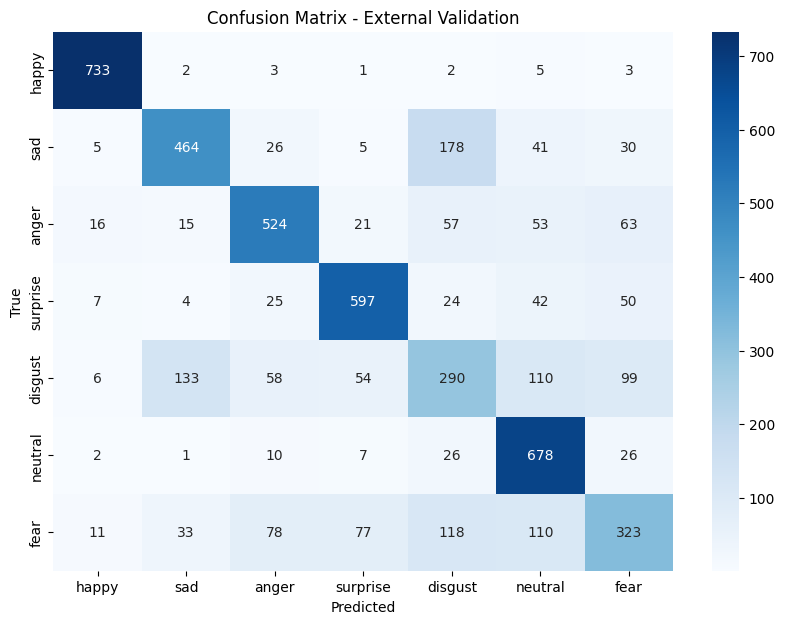

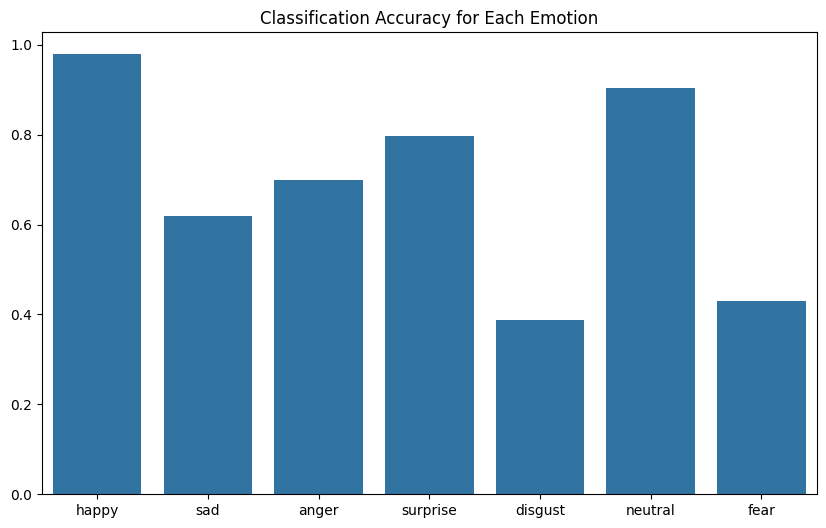

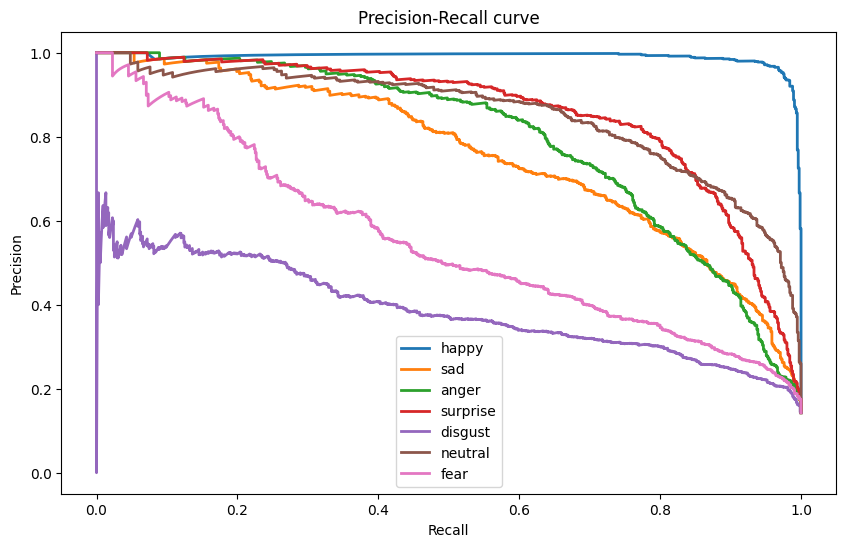

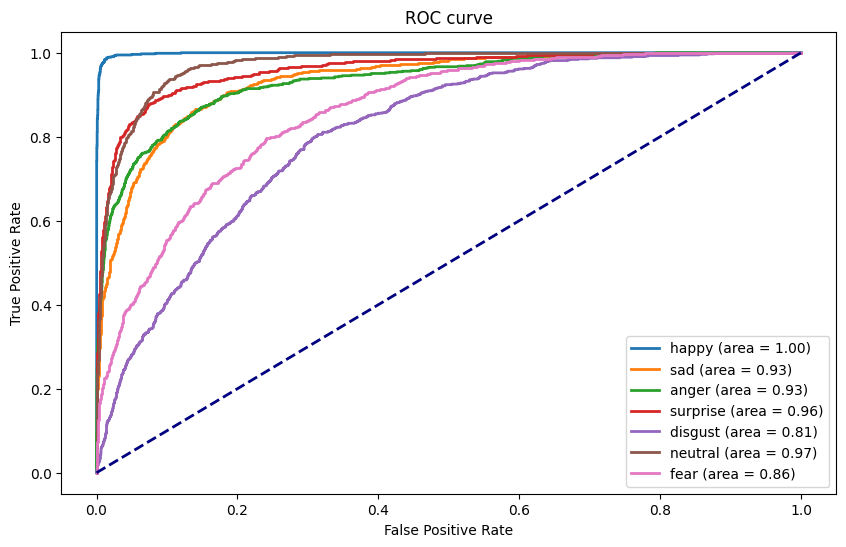

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

# 모델 로드
generator_path = '/content/drive/MyDrive/clean_0317/gan1_clean_0407_generator_model.h5'
combined_model_path = '/content/drive/MyDrive/clean_0317/gan1_clean_0407_combined_model.h5'
# 모델 로드 후 수동 컴파일
generator = tf.keras.models.load_model(generator_path)
combined_model = tf.keras.models.load_model(combined_model_path)
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 감정 레이블 정의
emotion_labels = {
    "happy": 0, "sad": 1, "anger": 2, "surprise": 3,
    "disgust": 4, "neutral": 5, "fear": 6,
}

# landmark indices 정의
landmark_indices = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46, 300, 293, 334, 296, 336, 285, 295, 282, 283, 276, 33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7, 263, 466, 388, 387, 386, 385, 384, 398, 362, 382, 381, 380, 374, 373, 390, 249, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95, 61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 375, 321, 405, 314, 17, 84, 181, 91, 146, 64, 4, 294, 168, 6, 197, 195, 5, 1]

# landmark 추출 함수 정의
def extract_selected_landmarks(landmarks):
    selected_landmarks = tf.gather(landmarks, indices=landmark_indices, axis=0)
    return tf.reshape(selected_landmarks, [len(landmark_indices) * 3])

def calculate_z_value_combinations(z_values):
    z_combinations = list(itertools.combinations(range(8), 3))
    z_product_combinations = []

    for indices in z_combinations:
        selected_values = tf.gather(z_values, indices)
        product = tf.reduce_prod(selected_values)
        z_product_combinations.append(product)

    return tf.stack(z_product_combinations)

# TFRecord 파싱 함수
def parse_and_prepare_tfrecord(tfrecord):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "landmarks": tf.io.VarLenFeature(tf.float32),
        "label": tf.io.FixedLenFeature([], tf.int64),
        "z_values": tf.io.FixedLenFeature([8], tf.float32),  # 기본값 수정
    }
    parsed_features = tf.io.parse_single_example(tfrecord, features)

    image = tf.io.decode_jpeg(parsed_features["image"])
    image = tf.image.rgb_to_grayscale(image)
    image = tf.expand_dims(image, -1)
    image = tf.squeeze(image, axis=-1)
    image = tf.cast(image, tf.float32) * (2. / 255) - 1 # 정확도 높이기 위해 추가


    landmarks = tf.sparse.to_dense(parsed_features["landmarks"])
    landmarks = tf.reshape(landmarks, [-1, 3])
    selected_landmarks = extract_selected_landmarks(landmarks)
    selected_landmarks.set_shape([303])

    label = tf.one_hot(parsed_features["label"], depth=len(emotion_labels))

    z_values = parsed_features["z_values"]
    z_product_combinations = calculate_z_value_combinations(z_values)

    return (image, selected_landmarks, z_product_combinations), label

# 데이터셋 로드 및 준비
def load_and_prepare_dataset(tfrecord_file, batch_size=None):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(parse_and_prepare_tfrecord)
    if batch_size is not None:
        dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# 검증 데이터셋 파일 경로 설정
external_validation_tfrecord = '/content/drive/MyDrive/clean_0317/External/ext_YES_Z_test_shuffled.tfrecord'

# 검증 데이터셋 로드
external_validation_dataset = load_and_prepare_dataset(external_validation_tfrecord, batch_size=16)

# 모델 평가
test_images = []
test_landmarks = []
test_z_values = []
y_test = []

for (image, landmark, z_value), label in external_validation_dataset:
    test_images.append(image)
    test_landmarks.append(landmark)
    y_test.extend(label.numpy())
    test_z_values.append(z_value)

y_test = np.argmax(y_test, axis=1)
y_test_pred = combined_model.predict([np.vstack(test_images), np.vstack(test_landmarks), np.vstack(test_z_values)])
y_test_pred = np.argmax(y_test_pred, axis=1)

# 정확도 계산
test_accuracy = accuracy_score(y_test, y_test_pred)
print("External Validation Accuracy:", test_accuracy)

# 혼돈 행렬 생성 및 시각화
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - External Validation')
plt.savefig('/content/drive/MyDrive/clean_0317/External/ext_confusion_matrix.png')


# 각각의 감정에 대한 분류 정확도 계산 및 시각화
emotion_accuracy_dict = {}
for emotion in emotion_labels:
    emotion_index = emotion_labels[emotion]
    emotion_accuracy = accuracy_score(y_test[y_test == emotion_index], y_test_pred[y_test == emotion_index])
    emotion_accuracy_dict[emotion] = emotion_accuracy
    print(f"Accuracy for {emotion}: {emotion_accuracy:.2f}")

# 감정별 정확도를 바 차트로 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_accuracy_dict.keys()), y=list(emotion_accuracy_dict.values()))
plt.title('Classification Accuracy for Each Emotion')
plt.savefig('/content/drive/MyDrive/clean_0317/External/ext_emotion_accuracy.png')


# 정밀도, 재현율, F1 스코어 계산
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# AUC 스코어 계산
# 감정 레이블이 다중 클래스이므로, AUC 계산을 위해 one-vs-rest 방식을 적용해야 합니다.
# 각 클래스에 대해 확률을 계산해야 하므로, 모델의 예측을 확률로 변경합니다.
y_test_prob = combined_model.predict([np.vstack(test_images), np.vstack(test_landmarks), np.vstack(test_z_values)])
roc_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.2f}")

# PR 곡선 그리기
precision_dict = {}
recall_dict = {}
plt.figure(figsize=(10, 6))
for i, emotion in enumerate(emotion_labels):
    precision_dict[emotion], recall_dict[emotion], _ = precision_recall_curve(y_test == i, y_test_prob[:, i])
    plt.plot(recall_dict[emotion], precision_dict[emotion], lw=2, label=f'{emotion}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.savefig('/content/drive/MyDrive/clean_0317/External/ext_precision_recall_curve.png')

# ROC 곡선 그리기
plt.figure(figsize=(10, 6))
for i, emotion in enumerate(emotion_labels):
    fpr, tpr, _ = roc_curve(y_test == i, y_test_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'{emotion} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="best")
plt.savefig('/content/drive/MyDrive/clean_0317/External/ext_roc_curve.png')